In [1]:
import torch
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Do data preproccessing

In [2]:
SOS_token = 0
EOS_token = 1

class DataPreproccessing:
    def __init__(self, name):
        self.name = name        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:            
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
import regex as re
import unicodedata
import string

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    return text

In [4]:
from pathlib import Path
path_downloads = Path.home() / "Downloads"

In [5]:
name_data = 'small_data.txt'
url_train = path_downloads / name_data

In [6]:
def read_lines(input, output, url_train, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(url_train, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[clean_text(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input = DataPreproccessing(output)
        output = DataPreproccessing(input)
    else:
        input = DataPreproccessing(input)
        output = DataPreproccessing(output)

    return input, output, pairs

In [7]:
MAX_LENGTH = 32

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(url_train, input, output, reverse=False):
    input, output, pairs = read_lines(input, output, url_train, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

input, output, pairs = prepareData(url_train, 'questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
['nothing just testing you', 'ok lets proceed with the tests']


In [9]:
pairs.pop(0)

['questions', 'answers']

In [10]:
train_data = pd.DataFrame(pairs, columns=['questions', 'answers'])
display(train_data)

questions  \
0                   hello how are you   
1                    i am fine thanks   
2            nothing just testing you   
3                   how about my work   
4  do you know the company i work for   
5   you know what i do in the company   
6       good you know a lot of things   
7             how are you doing today   
8         i am doing great too thanks   
9               i will help you learn   

                                             answers  
0                            i am good how about you  
1                good so what you want to talk about  
2                     ok lets proceed with the tests  
3                        ok lets talk about you work  
4     yes you work at outtech it as python developer  
5  yes you develop erp softwares enterprise resou...  
6                                          sure i do  
7                    i am doing great what about you  
8        that is nice so what you want to talk about  
9                      that is great i love to learn

In [11]:
train_data.to_csv('train_data.txt', index=False)

print("DataFrame salvo com sucesso em 'train_data.txt'.")

DataFrame salvo com sucesso em 'train_data.txt'.


In [13]:
sns.histplot(data=train_data['questions'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

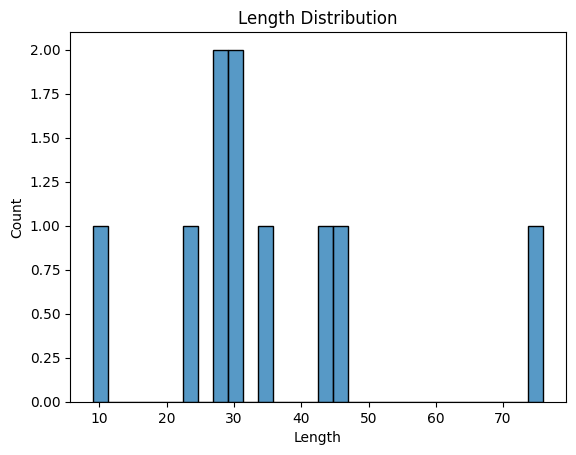

In [14]:
sns.histplot(data=train_data['answers'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

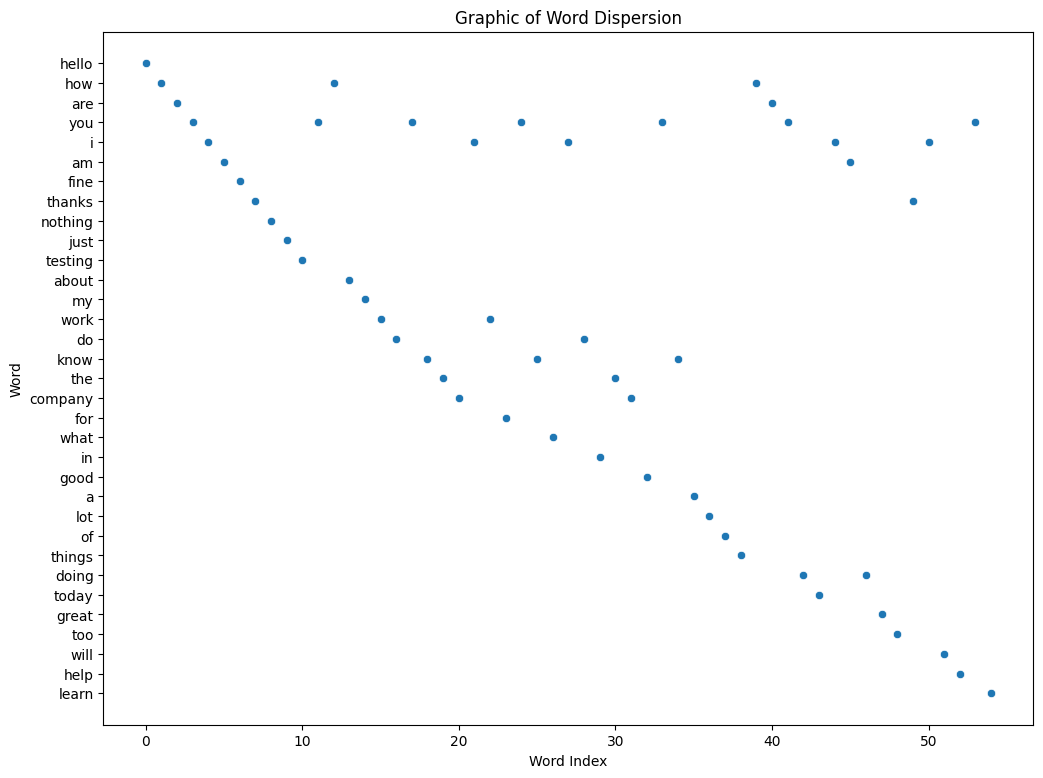

In [15]:
# word dispersion:
from itertools import chain
tokens = list(chain.from_iterable(train_data['questions'].apply(lambda x: x.split())))
plt.figure(figsize=(12, 9))
sns.scatterplot(x=range(len(tokens)), y=tokens)
plt.title('Graphic of Word Dispersion')
plt.xlabel('Word Index')
plt.ylabel('Word')
plt.show()

# old version without reinforcement learning

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [14]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData(url_train, 'questions', 'answers', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64)
    return input_lang, output_lang, train_dataloader

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [17]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder.eval()
        decoder.eval()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [18]:
def infer_sentence(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(1)

        encoder.eval()
        decoder.eval()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[SOS_token]], device=device)  # Início de sentença

        decoded_words = []
        decoder_attentions = []

        decoder_hidden = encoder_hidden

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions.append(decoder_attention.squeeze().cpu().detach().numpy())

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions

In [48]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import math
import torch.nn as nn
import torch.nn.functional as F

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 32

class NLPChatBot(nn.Module):
    def __init__(self, input_lang, output_lang, hidden_size=512, batch_size=64):
        super(NLPChatBot, self).__init__()

        self.input_lang = input_lang
        self.output_lang = output_lang
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device

        self.encoder = EncoderRNN(input_lang.n_words, hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)

    def forward(self, input_tensor, target_tensor):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)
        return decoder_outputs

    def indexesFromSentence(lang, sentence):
        return [lang.word2index[word] for word in sentence.split(' ')]
    
    def tensorFromSentence(lang, sentence):
        indexes = indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)
    
    def tensorsFromPair(pair):
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def get_dataloader(batch_size):
        input_lang, output_lang, pairs = prepareData(url_train, 'questions', 'answers', False)
    
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    
        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = indexesFromSentence(input_lang, inp)
            tgt_ids = indexesFromSentence(output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids
    
        train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64) # colocado na mão aqui
        return train_dataloader

    def train_epoch(self, dataloader, encoder_optimizer, decoder_optimizer, criterion):
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = self.encoder(input_tensor)
            decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def train(self, train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
        train_dataloader = self.get_dataloader()

        encoder.train()
        decoder.train()

        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=learning_rate)
        criterion = nn.NLLLoss()

        for epoch in range(1, n_epochs + 1):
            loss = self.train_epoch(train_dataloader, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if epoch % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (self.timeSince(start, epoch / n_epochs),
                                            epoch, epoch / n_epochs * 100, print_loss_avg))

            if epoch % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        self.showPlot(plot_losses)

    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))

    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def showPlot(self, points):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as ticker
        import numpy as np

        plt.figure()
        fig, ax = plt.subplots()
        loc = ticker.MultipleLocator(base=0.2)
        ax.yaxis.set_major_locator(loc)
        plt.plot(points)
        plt.show()

    class EncoderRNN(nn.Module):
        def __init__(self, input_size, hidden_size, dropout_p=0.1):
            super(EncoderRNN, self).__init__()
            self.hidden_size = hidden_size

            self.embedding = nn.Embedding(input_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, input):
            embedded = self.dropout(self.embedding(input))
            output, hidden = self.gru(embedded)
            return output, hidden

    class DecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(DecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self.device).fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
                decoder_outputs.append(decoder_output)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

        def forward_step(self, input, hidden):
            output = self.embedding(input)
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            output = self.out(output)
            return output, hidden

    class BahdanauAttention(nn.Module):
        def __init__(self, hidden_size):
            super(BahdanauAttention, self).__init__()
            self.Wa = nn.Linear(hidden_size, hidden_size)
            self.Ua = nn.Linear(hidden_size, hidden_size)
            self.Va = nn.Linear(hidden_size, 1)

        def forward(self, query, keys):
            scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
            scores = scores.squeeze(2).unsqueeze(1)

            weights = F.softmax(scores, dim=-1)
            context = torch.bmm(weights, keys)

            return context, weights

    class AttnDecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size, dropout_p=0.1):
            super(AttnDecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.attention = BahdanauAttention(hidden_size)
            self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []
            attentions = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attn_weights = self.forward_step(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_outputs.append(decoder_output)
                attentions.append(attn_weights)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            attentions = torch.cat(attentions, dim=1)

            return decoder_outputs, decoder_hidden, attentions


        def forward_step(self, input, hidden, encoder_outputs):
            embedded =  self.dropout(self.embedding(input))

            query = hidden.permute(1, 0, 2)
            context, attn_weights = self.attention(query, encoder_outputs)
            input_gru = torch.cat((embedded, context), dim=2)

            output, hidden = self.gru(input_gru, hidden)
            output = self.out(output)

            return output, hidden, attn_weights


input, output, train_dataloader = get_dataloader(batch_size=64)

model = NLPChatBot(input, output)
model.to(device)
model

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [21]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

4,529,711 total parameters.
4,529,711 training parameters.



Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
0m 0s (- 0m 17s) (5 5%) 1.5150
0m 1s (- 0m 11s) (10 10%) 0.6522
0m 1s (- 0m 8s) (15 15%) 0.3918
0m 1s (- 0m 7s) (20 20%) 0.2223
0m 2s (- 0m 6s) (25 25%) 0.1266
0m 2s (- 0m 5s) (30 30%) 0.0816
0m 2s (- 0m 4s) (35 35%) 0.0562
0m 2s (- 0m 4s) (40 40%) 0.0375
0m 3s (- 0m 3s) (45 45%) 0.0241
0m 3s (- 0m 3s) (50 50%) 0.0149
0m 3s (- 0m 3s) (55 55%) 0.0094
0m 4s (- 0m 2s) (60 60%) 0.0065
0m 4s (- 0m 2s) (65 65%) 0.0049
0m 4s (- 0m 1s) (70 70%) 0.0039
0m 4s (- 0m 1s) (75 75%) 0.0033
0m 5s (- 0m 1s) (80 80%) 0.0029
0m 5s (- 0m 0s) (85 85%) 0.0026
0m 5s (- 0m 0s) (90 90%) 0.0023
0m 6s (- 0m 0s) (95 95%) 0.0021
0m 6s (- 0m 0s) (100 100%) 0.0020


<Figure size 640x480 with 0 Axes>

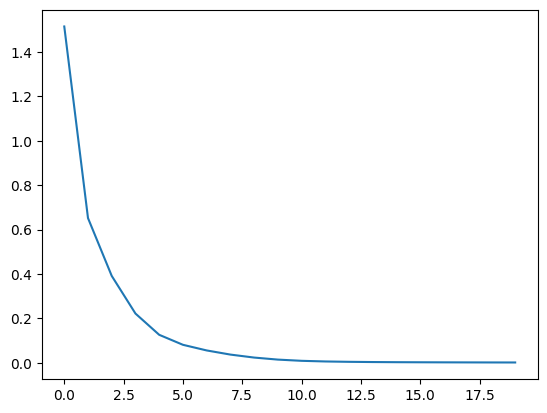

In [22]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)

# Treine o modelo usando a função train da BaseModel
model.train(train_dataloader, model.encoder, model.decoder, 100, print_every=5, plot_every=5)

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
0m 0s (- 0m 7s) (5 5%) 0.0110
0m 0s (- 0m 6s) (10 10%) 0.0018
0m 0s (- 0m 5s) (15 15%) 0.0007
0m 1s (- 0m 5s) (20 20%) 0.0004
0m 1s (- 0m 4s) (25 25%) 0.0002
0m 1s (- 0m 4s) (30 30%) 0.0002
0m 2s (- 0m 3s) (35 35%) 0.0001
0m 2s (- 0m 3s) (40 40%) 0.0001
0m 2s (- 0m 3s) (45 45%) 0.0001
0m 2s (- 0m 2s) (50 50%) 0.0001
0m 3s (- 0m 2s) (55 55%) 0.0000
0m 3s (- 0m 2s) (60 60%) 0.0000
0m 3s (- 0m 2s) (65 65%) 0.0000
0m 4s (- 0m 1s) (70 70%) 0.0000
0m 4s (- 0m 1s) (75 75%) 0.0000
0m 4s (- 0m 1s) (80 80%) 0.0000
0m 4s (- 0m 0s) (85 85%) 0.0000
0m 5s (- 0m 0s) (90 90%) 0.0000
0m 5s (- 0m 0s) (95 95%) 0.0000
0m 5s (- 0m 0s) (100 100%) 0.0000


<Figure size 640x480 with 0 Axes>

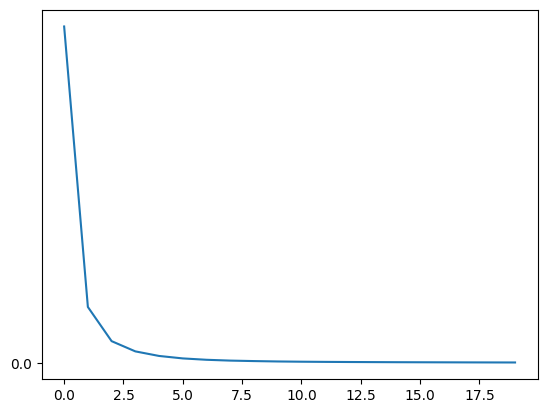

In [23]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)

model.encoder.train()
model.decoder.train()

# Treine o modelo usando a função train da BaseModel
model.train(train_dataloader, model.encoder, model.decoder, 100, print_every=5, plot_every=5)

In [24]:
model.encoder.eval()
model.decoder.eval()
evaluateRandomly(model.encoder, model.decoder)

> good you know a lot of things
= sure i do
< sure i do <EOS>

> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> good you know a lot of things
= sure i do
< sure i do <EOS>

> how are you doing today
= i am doing great what about you
< i am doing great what about you <EOS>

> i am fine thanks
= good so what you want to talk about
< good so what you want to talk about <EOS>

> hello how are you
= i am good how about you
< i am good how about you <EOS>

> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> how about my work
= ok lets talk about you work
< ok lets talk about you work <EOS>

> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> good you know a lot of things
= sure i do
< sure i do <EOS>



In [21]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

input = hello how are you
output = i am good how about you <EOS>


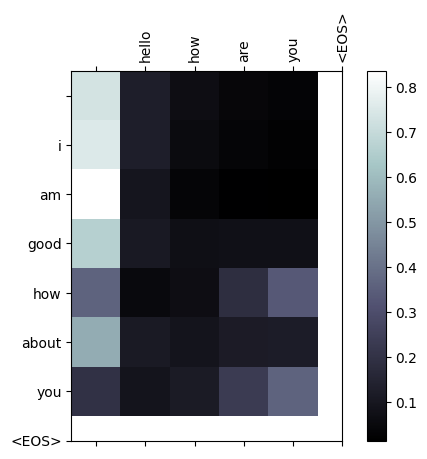

input = i am fine thanks
output = good so what you want to talk about <EOS>


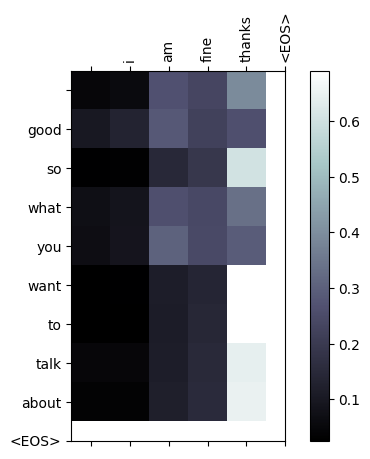

input = nothing just testing you
output = ok lets proceed with the tests <EOS>


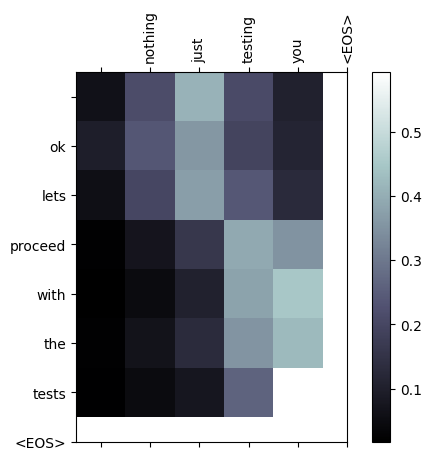

input = how about my work
output = ok lets talk about you work <EOS>


In [25]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Definir os ticks para evitar UserWarnings
    ax.set_xticks(range(len(input_sentence.split(' ')) + 2))
    ax.set_yticks(range(len(output_words) + 1))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.set_yticklabels([''] + output_words)

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

text = clean_text("hello how are you")

evaluateAndShowAttention(text)

text = clean_text("i am fine thanks")

evaluateAndShowAttention(text)

text = clean_text("nothing just testing you")

evaluateAndShowAttention(text)

text = clean_text("how about my work")

evaluateAndShowAttention(text)

In [26]:
from pathlib import Path

# save the model state dict and optimizers
def save(model, model_path, encoder_optimizer, decoder_optimizer, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'epoch': epoch,  # Salve o número da última época se aplicável
        'loss': loss,    # Salve a última loss se aplicável
    }, model_path)
    return print(f"Saved the model and optimizers to {model_path}")

In [21]:
MODEL_NAME = 'PyTorch_ChatBotNN_v2.pth'
MODEL_SAVE_PATH = path_downloads / MODEL_NAME

In [22]:
encoder_optimizer = torch.optim.Adam(params=model.encoder.parameters(),
                            lr=0.001)
decoder_optimizer = torch.optim.Adam(params=model.decoder.parameters(),
                            lr=0.001)

In [29]:
epoch = False
loss = False
save(model=model, model_path=MODEL_SAVE_PATH, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, epoch=epoch if epoch else False, loss=loss if loss else False)

Saved the model and optimizers to C:\Users\RFFSo\Downloads\PyTorch_ChatBotNN_v2.pth


In [23]:
def loading(model_path, device, model, class_name, encoder_optim, decoder_optim):
    # Carregamento do modelo
    checkpoint = torch.load(model_path, map_location=torch.device(device)) 
    
    input, output, train_dataloader = get_dataloader(batch_size=64)
    
    # Crie uma instância do modelo com a classe fornecida
    model = class_name(input, output) 
    
    # Carregue o estado do modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Crie os otimizadores com os parâmetros do modelo
    encoder_optim = torch.optim.Adam(params=model.encoder.parameters(),
                                     lr=0.001)
    decoder_optim = torch.optim.Adam(params=model.decoder.parameters(),
                                     lr=0.001)
    
    # Carregue os estados dos otimizadores
    encoder_optim.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optim.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
    # Recupere informações sobre a última época e loss se aplicável
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else 0
    loss = checkpoint['loss'] if 'loss' in checkpoint else None
    
    # Mova o modelo e os otimizadores para o dispositivo desejado
    model.to(device)
    
    return model

In [29]:
encoder_optimizer = torch.optim.Adam(params=model.encoder.parameters(),
                            lr=0.001)
decoder_optimizer = torch.optim.Adam(params=model.decoder.parameters(),
                            lr=0.001)

In [27]:
MODEL_NAME = 'PyTorch_ChatBotNN_v2.pth'
MODEL_SAVE_PATH = path_downloads / MODEL_NAME

In [24]:
model = loading(model_path=MODEL_SAVE_PATH, device=device, model=model, class_name=NLPChatBot, encoder_optim=encoder_optimizer, decoder_optim=decoder_optimizer)
model

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [25]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)
model.encoder.eval()
model.decoder.eval()
evaluateRandomly(model.encoder, model.decoder)

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
> hello how are you
= i am good how about you
< i am good how about you <EOS>

> how are you doing today
= i am doing great what about you
< i am doing great what about you <EOS>

> i am fine thanks
= good so what you want to talk about
< good so what you want to talk about <EOS>

> do you know the company i work for
= yes you work at outtech it as python developer
< yes you work at outtech it as python developer <EOS>

> hello how are you
= i am good how about you
< i am good how about you <EOS>

> good you know a lot of things
= sure i do
< sure i do <EOS>

> hello how are you
= i am good how about you
< i am good how about you <EOS>

> i will help you learn
= that is great i love to learn
< that is great i love to learn <EOS>

> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> do you know the company i work f

In [27]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input, output)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

In [43]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)


def main():
    while True:
        mic = sr.Recognizer()
        mic.pause_threshold = 1.7
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main()
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main()

        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            else:
                try:
                    resp = evaluateAndShowAttention(query)
                    resp = str(resp)
                    resp = resp.replace('<EOS>', '0')
                    resp = clean_text(resp)
                    if 'sos' in resp:
                        resp = resp.replace('sos', '')
                        resp = clean_text("'i don't understand")
                        print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
                except KeyError as exception:
                    resp = clean_text("i don't know one of the words you said")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
        else:
            main()

main()

speak...
Você disse: hello how are you
input = hello how are you
output = i am good how about you <EOS>
speak...
Você disse: I am fine thanks
input = i am fine thanks
output = good so what you want to talk about <EOS>
speak...
Você disse: nothing just testing you
input = nothing just testing you
output = ok lets proceed with the tests <EOS>
speak...
Você disse: how about my work
input = how about my work
output = ok lets talk about your work <EOS>
speak...
Você disse: do you know the company I work for
input = do you know the company i work for
output = yes you work at outtech it as python developer <EOS>
speak...
Você disse: good you know a lot of things
input = good you know a lot of things
output = sure i do <EOS>
speak...
Você disse: how are you doing today
input = how are you doing today
output = i am doing great what about you <EOS>
speak...
Você disse: I am doing great too thanks
input = i am doing great too thanks
output = that is nice so what you want to talk about <EOS>
speak

# Now Let's enhance the model by making an reinforcement learning

In [20]:
MAX_LENGTH = 32

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import math
import torch.nn as nn
import torch.nn.functional as F

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 32

class NLPChatBot(nn.Module):
    def __init__(self, input_lang, output_lang, hidden_size=512, batch_size=64):
        super(NLPChatBot, self).__init__()

        self.input_lang = input_lang
        self.output_lang = output_lang
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = "cpu"

        self.encoder = EncoderRNN(input_lang.n_words, hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)

    def forward(self, input_tensor, target_tensor):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)
        return decoder_outputs

    def indexesFromSentence(lang, sentence):
        return [lang.word2index[word] for word in sentence.split(' ')]
    
    def tensorFromSentence(lang, sentence):
        indexes = indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device="cpu").view(1, -1)
    
    def tensorsFromPair(pair):
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def get_dataloader(batch_size):
        input_lang, output_lang, pairs = prepareData(url_train, 'questions', 'answers', False)
    
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    
        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = indexesFromSentence(input_lang, inp)
            tgt_ids = indexesFromSentence(output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids
    
        train_data = TensorDataset(torch.LongTensor(input_ids).to("cpu"),
                               torch.LongTensor(target_ids).to("cpu"))

        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64) # colocado na mão aqui
        return train_dataloader

    def train_epoch(self, dataloader, encoder_optimizer, decoder_optimizer, criterion):
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = self.encoder(input_tensor)
            decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def train(self, train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
        train_dataloader = self.get_dataloader()

        encoder.train()
        decoder.train()

        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=learning_rate)
        criterion = nn.NLLLoss()

        for epoch in range(1, n_epochs + 1):
            loss = self.train_epoch(train_dataloader, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if epoch % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (self.timeSince(start, epoch / n_epochs),
                                            epoch, epoch / n_epochs * 100, print_loss_avg))

            if epoch % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        self.showPlot(plot_losses)

    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))

    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def showPlot(self, points):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as ticker
        import numpy as np

        plt.figure()
        fig, ax = plt.subplots()
        loc = ticker.MultipleLocator(base=0.2)
        ax.yaxis.set_major_locator(loc)
        plt.plot(points)
        plt.show()

    class EncoderRNN(nn.Module):
        def __init__(self, input_size, hidden_size, dropout_p=0.1):
            super(EncoderRNN, self).__init__()
            self.hidden_size = hidden_size

            self.embedding = nn.Embedding(input_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, input):
            embedded = self.dropout(self.embedding(input))
            output, hidden = self.gru(embedded)
            return output, hidden

    class DecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(DecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self.device).fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
                decoder_outputs.append(decoder_output)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

        def forward_step(self, input, hidden):
            output = self.embedding(input)
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            output = self.out(output)
            return output, hidden

    class BahdanauAttention(nn.Module):
        def __init__(self, hidden_size):
            super(BahdanauAttention, self).__init__()
            self.Wa = nn.Linear(hidden_size, hidden_size)
            self.Ua = nn.Linear(hidden_size, hidden_size)
            self.Va = nn.Linear(hidden_size, 1)

        def forward(self, query, keys):
            scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
            scores = scores.squeeze(2).unsqueeze(1)

            weights = F.softmax(scores, dim=-1)
            context = torch.bmm(weights, keys)

            return context, weights

    class AttnDecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size, dropout_p=0.1):
            super(AttnDecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.attention = BahdanauAttention(hidden_size)
            self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device="cpu").fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []
            attentions = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attn_weights = self.forward_step(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_outputs.append(decoder_output)
                attentions.append(attn_weights)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            attentions = torch.cat(attentions, dim=1)

            return decoder_outputs, decoder_hidden, attentions


        def forward_step(self, input, hidden, encoder_outputs):
            embedded =  self.dropout(self.embedding(input))

            query = hidden.permute(1, 0, 2)
            context, attn_weights = self.attention(query, encoder_outputs)
            input_gru = torch.cat((embedded, context), dim=2)

            output, hidden = self.gru(input_gru, hidden)
            output = self.out(output)

            return output, hidden, attn_weights


input, output, train_dataloader = get_dataloader(batch_size=64)

model = NLPChatBot(input, output)
model.to("cpu")
model

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [71]:
model = loading(model_path=MODEL_SAVE_PATH, device="cpu", model=model, class_name=NLPChatBot, encoder_optim=encoder_optimizer, decoder_optim=decoder_optimizer)
model

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [31]:
def prepareData(url_train, input, output, reverse=False):
    input, output, pairs = read_lines(input, output, url_train, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

input, output, pairs = prepareData(url_train, 'questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
['i am fine thanks', 'good so what you want to talk about']


In [32]:
input.n_words, output.n_words

(36, 46)

In [33]:
from pathlib import Path

# save the model state dict and optimizers
def save(model, model_path, encoder_optimizer, decoder_optimizer, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'epoch': epoch,  # Salve o número da última época se aplicável
        'loss': loss,    # Salve a última loss se aplicável
    }, model_path)
    return print(f"Saved the model and optimizers to {model_path}")

In [177]:
def loading(model_path, device, model, class_name, encoder_optim, decoder_optim):
    # Carregamento do modelo
    checkpoint = torch.load(model_path, map_location=torch.device(device))

    input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)
    
    # Crie uma instância do modelo com a classe fornecida
    model = class_name(input, output)  # Substitua input_lang e output_lang pelos seus objetos

    state_dict = checkpoint['model_state_dict']

    model.load_state_dict(state_dict, strict=False)

    # Carregar o estado do modelo
    # model.load_state_dict(state_dict, strict=False)

    # Resize encoder embedding (assuming checkpoint vocabulary is smaller)
    new_enc_embedding_size = input_lang.n_words  # Use actual vocabulary size
    new_dec_embedding_size = output_lang.n_words
    
    # Ajustar as dimensões dos embeddings no state_dict
    if 'encoder.embedding.weight' in state_dict:
        state_dict['encoder.embedding.weight'] = state_dict['encoder.embedding.weight'][:new_enc_embedding_size, :]
    
    if 'decoder.embedding.weight' in state_dict:
        state_dict['decoder.embedding.weight'] = state_dict['decoder.embedding.weight'][:new_dec_embedding_size, :]
    
    if 'decoder.out.weight' in state_dict:
        state_dict['decoder.out.weight'] = state_dict['decoder.out.weight'][:new_dec_embedding_size, :]
    
    # Atribuir o state_dict ajustado de volta ao modelo
    model.load_state_dict(state_dict, strict=False)

    model = class_name(input_lang, output_lang)
       
    # Crie os otimizadores com os parâmetros do modelo
    encoder_optim = torch.optim.Adam(params=model.encoder.parameters(), lr=0.001)
    decoder_optim = torch.optim.Adam(params=model.decoder.parameters(), lr=0.001)
    
    # Carregue os estados dos otimizadores
    encoder_optim.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optim.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
    # Recupere informações sobre a última época e loss se aplicável
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else 0
    loss = checkpoint['loss'] if 'loss' in checkpoint else None
    
    # Mova o modelo e os otimizadores para o dispositivo desejado
    model.to(device)
    
    return model

In [179]:
# a célula acima não consegue dar load sem perdedr o treino

In [65]:
def loading(model_path, device, model, class_name, encoder_optim, decoder_optim):
    # Carregamento do modelo
    checkpoint = torch.load(model_path, map_location=torch.device(device)) 
    
    input, output, train_dataloader = get_dataloader(batch_size=64)
    
    # Crie uma instância do modelo com a classe fornecida
    model = class_name(input, output) 
    
    # Carregue o estado do modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Crie os otimizadores com os parâmetros do modelo
    encoder_optim = torch.optim.Adam(params=model.encoder.parameters(),
                                     lr=0.001)
    decoder_optim = torch.optim.Adam(params=model.decoder.parameters(),
                                     lr=0.001)
    
    # Carregue os estados dos otimizadores
    encoder_optim.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optim.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
    # Recupere informações sobre a última época e loss se aplicável
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else 0
    loss = checkpoint['loss'] if 'loss' in checkpoint else None
    
    # Mova o modelo e os otimizadores para o dispositivo desejado
    model.to(device)
    
    return model

In [34]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device="cpu").view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData(url_train, 'questions', 'answers', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to("cpu"),
                               torch.LongTensor(target_ids).to("cpu"))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=64)
    return input_lang, output_lang, train_dataloader

In [35]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder.eval()
        decoder.eval()

        encoder_outputs, encoder_hidden = model.encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = model.decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [36]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input, output)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

In [37]:
test = evaluateAndShowAttention('i will help you learn')

input = i will help you learn
output = that is great i love to learn <EOS>


In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [14]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device="cpu").fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [38]:
def reinforcement_train(model_loaded):
    model_loaded.input_lang, model_loaded.output_lang, train_dataloader = get_dataloader(batch_size=64)

    model_loaded.encoder.train()
    model_loaded.decoder.train()
    
    # Treine o modelo usando a função train da BaseModel
    model_loaded.train(train_dataloader, model_loaded.encoder, model_loaded.decoder, 26, print_every=5, plot_every=5)

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
0m 0s (- 0m 3s) (1 20%) 0.0000
0m 1s (- 0m 1s) (2 40%) 0.0000
0m 1s (- 0m 0s) (3 60%) 0.0000
0m 1s (- 0m 0s) (4 80%) 0.0000
0m 2s (- 0m 0s) (5 100%) 0.0000


<Figure size 640x480 with 0 Axes>

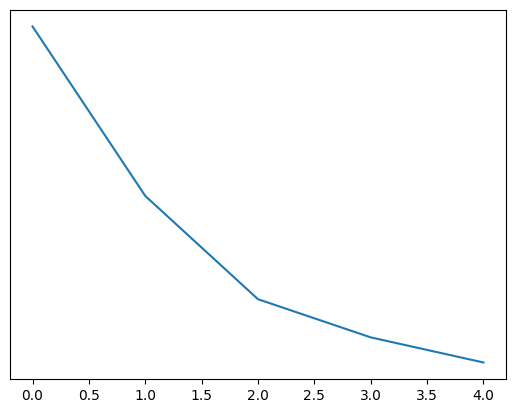

In [91]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)

model.encoder.train()
model.decoder.train()

# Treine o modelo usando a função train da BaseModel
model.train(train_dataloader, model.encoder, model.decoder, 5, print_every=1, plot_every=1)

In [39]:
model.encoder.to("cpu")
model.decoder.to("cpu")

AttnDecoderRNN(
  (embedding): Embedding(46, 512)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=512, out_features=512, bias=True)
    (Ua): Linear(in_features=512, out_features=512, bias=True)
    (Va): Linear(in_features=512, out_features=1, bias=True)
  )
  (gru): GRU(1024, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=46, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [40]:
name_data = 'train_data.txt'
url_train = path_downloads / name_data

In [41]:
def append_data(url_train, input_text, output_text):
    with open(url_train, 'a') as file:
        file.write(f'{input_text},{output_text}\n')

In [42]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input, output)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

In [43]:
def speak():
    mic = sr.Recognizer()
    mic.pause_threshold = 1.7
    with sr.Microphone() as source:
        mic.adjust_for_ambient_noise(source)
        source.SAMPLE_WIDTH = 2
        print("speak...")
        audio  = mic.listen(source)
    try:
        # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
        comando = mic.recognize_google(audio, language="en-us")
        print(f"Você disse: {comando}")
    except sr.UnknownValueError:
        tts = gTTS(text="sorry, i couldn't understand", lang="en")
        tts.save("said.mp3")
        AudioPlayer("said.mp3").play(block=True)
        main(input_lang, output_lang)
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))
        main(input_lang, output_lang)

    if len(comando) > 0:
        query = comando.lower()
        query = clean_text(query)
        return query

    else:
        print("there is no query")
        main(input_lang, output_lang)

In [44]:
def read_lines(input, output, url_train, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(url_train, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[clean_text(s) for s in l.split(',')] for l in lines]

    # Reverse pairs, make instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input = DataPreproccessing(output)
        output = DataPreproccessing(input)
    else:
        input = DataPreproccessing(input)
        output = DataPreproccessing(output)

    return input, output, pairs

In [45]:
def prepareData(url_train, input, output, reverse=False):
    input, output, pairs = read_lines(input, output, url_train, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

In [ ]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)

model_loaded = False

def main(input_lang, output_lang):
    model.to("cpu")
    while True:
        mic = sr.Recognizer()
        mic.pause_threshold = 1.7
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main(model.input_lang, model.output_lang)
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main(model.input_lang, model.output_lang)

        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            else:
                try:
                    resp = evaluateAndShowAttention(query)
                    resp = str(resp)
                    resp = resp.replace('<EOS>', '0')
                    resp = clean_text(resp)
                    if 'sos' in resp:
                        resp = resp.replace('sos', '')
                        resp = clean_text("'i don't understand")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                        
                        resp = clean_text("please say a correct answer to you phrase")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        x = speak()
    
                        print("your phrase: ", query)
                        print("correct answer: ", x)                   
    
                        question = f"Ok, so the correct answer to {query}, is {x}?"
    
                        resp = clean_text(question)
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        y = speak()
    
                        if 'yes' in y:
                            resp = clean_text("ok so i will train with new data")
                            print(resp)
                            tts = gTTS(text=resp, lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)
        
                            # add response and query in data
                            append_data(url_train, query, x)  # add new data entry
    
                            model.input_lang.addSentence(query)
                            model.output_lang.addSentence(x)
                            input_lang.addSentence(query)
                            output_lang.addSentence(x)

                            model_loaded = loading(model_path=MODEL_SAVE_PATH, device="cpu", model=model, class_name=NLPChatBot, encoder_optim=encoder_optimizer, decoder_optim=decoder_optimizer)
                
                            # train with new data entry
                            reinforcement_train(model_loaded)

                            tts = gTTS(text="training finished", lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)     
                            
                            main(model_loaded.input_lang, model_loaded.output_lang)                            
                        else:
                            resp = clean_text("OK!")
                            print(resp)
                            tts = gTTS(text=resp, lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)
                            main(model.input_lang, model.output_lang)
                    else:
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                except KeyError as exception:
                    unknown_word = exception.args[0]
                    resp = clean_text(f"I don't know one of the words you said: {unknown_word}")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)

                    resp = clean_text("please say a correct answer to you phrase")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)

                    x = speak()

                    print("yout phrase: ", query)
                    print("correct answer: ", x)                   

                    question = f"Ok, so the correct answer to {query}, is {x}?"

                    resp = clean_text(question)
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)

                    y = speak()

                    if 'yes' in y:
                        resp = clean_text("ok so i will train with new data")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        # add response and query in data
                        append_data(url_train, query, x)  # add new data entry

                        model.input_lang.addSentence(query)
                        model.output_lang.addSentence(x)
                        input_lang.addSentence(query)
                        output_lang.addSentence(x)

                        model_loaded = loading(model_path=MODEL_SAVE_PATH, device="cpu", model=model, class_name=NLPChatBot, encoder_optim=encoder_optimizer, decoder_optim=decoder_optimizer)

                        # train with new data entry
                        reinforcement_train(model_loaded)

                        tts = gTTS(text="training finished", lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)     
                        
                        main(model_loaded.input_lang, model_loaded.output_lang)
                    else:
                        resp = clean_text("OK!")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                        main(model.input_lang, model.output_lang)
        else:
            main(model.input_lang, model.output_lang)

main(model.input_lang, model.output_lang)

In [83]:
MODEL_NAME = 'PyTorch_ChatBotNN_v2.pth'
MODEL_SAVE_PATH = path_downloads / MODEL_NAME

In [ ]:
epoch = False
loss = False
save(model=model, model_path=MODEL_SAVE_PATH, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, epoch=epoch if epoch else False, loss=loss if loss else False)

In [181]:
model

NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [182]:
input_lang.n_words

37

In [ ]:
encoder_embedding = model.encoder.embedding

# Modifique o valor do input do encoder
new_input_size = input_lang.n_words  # O novo tamanho do vocabulário
new_embedding = torch.nn.Embedding(new_input_size, 512)  # Crie um novo embedding com o tamanho correto
new_embedding.weight.data.copy_(encoder_embedding.weight.data[:new_input_size, :])  # Copie os pesos do embedding original
model.encoder.embedding = new_embedding  # Atribua o novo embedding ao modelo

In [188]:
model.encoder.embedding

Embedding(36, 512)

In [211]:
model.decoder.out

Linear(in_features=512, out_features=46, bias=True)

In [246]:
# Acesse o embedding atual do decoder.out
decoder_out_embedding = model.decoder.out

# Obtenha o novo tamanho do vocabulário
new_output_size = output_lang.n_words  # Substitua pelo tamanho desejado

# Crie um novo embedding com o tamanho correto
new_embedding_out = torch.nn.Linear(decoder_out_embedding.in_features, new_output_size)

# Copie os pesos do embedding atual para o novo embedding, ajustando as dimensões
new_embedding_out.weight.data[:decoder_out_embedding.weight.size(0), :] = decoder_out_embedding.weight.data

# Substitua o embedding antigo pelo novo no decoder.out
model.decoder.out = new_embedding_out

RuntimeError: The expanded size of the tensor (46) must match the existing size (47) at non-singleton dimension 0.  Target sizes: [46, 512].  Tensor sizes: [47, 512]

In [244]:
model

NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=47, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [72]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)
model.encoder.eval()
model.decoder.eval()
evaluateRandomly(model.encoder, model.decoder)

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> nothing just testing you
= ok lets proceed with the tests
< ok lets proceed with the tests <EOS>

> how about my work
= ok lets talk about you work
< ok lets talk about you work <EOS>

> how about my work
= ok lets talk about you work
< ok lets talk about you work <EOS>

> hello how are you
= i am good how about you
< i am good how about you <EOS>

> hello how are you
= i am good how about you
< i am good how about you <EOS>

> do you know the company i work for
= yes you work at outtech it as python developer
< yes you work at outtech it as python developer <EOS>

> i am doing great too thanks
= that is nice so what you want to talk about
< that is nice so what you want to talk about <EOS>

> questions
= answers
< answers <EOS>

> you know what i do in the comp

In [195]:
input_lang.n_words

36

In [204]:
# Acesse o embedding atual do encoder
encoder_embedding = model.encoder.embedding

# Obtenha o novo tamanho do vocabulário
new_input_size = 37  # Substitua pelo tamanho desejado

# Crie um novo embedding com o tamanho correto
new_embedding = torch.nn.Embedding(new_input_size, encoder_embedding.embedding_dim)

# Copie os pesos do embedding atual para o novo embedding, ajustando as dimensões
new_weight = torch.zeros_like(new_embedding.weight)
current_weight = encoder_embedding.weight.data
new_weight[:current_weight.size(0), :] = current_weight

# Atribua o novo peso ao embedding do encoder
new_embedding.weight = torch.nn.Parameter(new_weight)

# Substitua o embedding antigo pelo novo no encoder
model.encoder.embedding = new_embedding

In [50]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)
model.encoder.eval()
model.decoder.eval()
evaluateRandomly(model.encoder, model.decoder)

Reading lines...
Read 11 sentence pairs
Trimmed to 11 sentence pairs
Counting words...
Counted words:
questions 36
answers 46
> you know what i do in the company
= yes you develop erp softwares enterprise resource and planning for companies
< yes you develop erp softwares enterprise resource and planning for companies <EOS>

> do you know the company i work for
= yes you work at outtech it as python developer
< yes you work at outtech it as python developer <EOS>

> i am doing great too thanks
= that is nice so what you want to talk about
< that is nice so what you want to talk about <EOS>

> questions
= answers
< answers <EOS>

> i am doing great too thanks
= that is nice so what you want to talk about
< that is nice so what you want to talk about <EOS>

> how are you doing today
= i am doing great what about you
< i am doing great what about you <EOS>

> you know what i do in the company
= yes you develop erp softwares enterprise resource and planning for companies
< yes you develop 

In [46]:
model # success!

NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(36, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(46, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=46, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [51]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, model.input_lang, model.output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

speak...
Você disse: hello how are you
input = hello how are you
output = i am good how about you <EOS>
speak...
Você disse: I am fine thanks
input = i am fine thanks
output = good so what you want to talk about <EOS>
speak...
Você disse: I will help you learn
input = i will help you learn
output = that is great i love to learn <EOS>
speak...
Você disse: so do you want to talk about the future
i do not know one of the words you said so
please say a correct answer to you phrase
speak...
Você disse: no I cannot predict the future
yout phrase:  so do you want to talk about the future
correct answer:  no i cannot predict the future
ok so the correct answer to so do you want to talk about the future is no i cannot predict the future
speak...
Você disse: yes
ok so i will train with new data
Reading lines...
Read 12 sentence pairs
Trimmed to 12 sentence pairs
Counting words...
Counted words:
questions 41
answers 50
Reading lines...
Read 12 sentence pairs
Trimmed to 12 sentence pairs
Counting 

<Figure size 640x480 with 0 Axes>

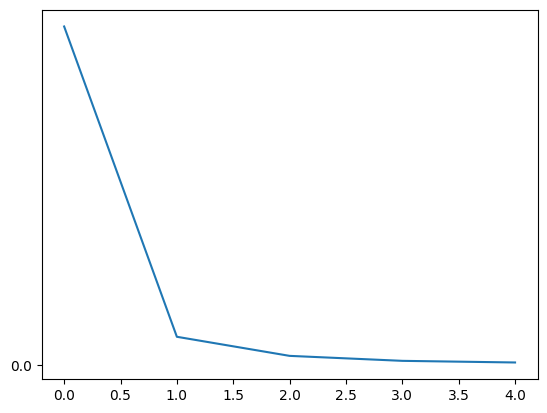

speak...
Você disse: so do you want to talk about the future
input = so do you want to talk about the future
output = no i cannot predict the future <EOS>
speak...
Você disse: but we can talk about the future
i do not know one of the words you said but
please say a correct answer to you phrase
speak...
Você disse: yes we can but it's too uncertain
yout phrase:  but we can talk about the future
correct answer:  yes we can but it is too uncertain
ok so the correct answer to but we can talk about the future is yes we can but it is too uncertain
speak...
Você disse: yes
ok so i will train with new data
Reading lines...
Read 13 sentence pairs
Trimmed to 13 sentence pairs
Counting words...
Counted words:
questions 44
answers 55
Reading lines...
Read 13 sentence pairs
Trimmed to 13 sentence pairs
Counting words...
Counted words:
questions 44
answers 55
0m 1s (- 0m 6s) (5 19%) 0.0727
0m 2s (- 0m 4s) (10 38%) 0.0118
0m 4s (- 0m 3s) (15 57%) 0.0031
0m 5s (- 0m 1s) (20 76%) 0.0012
0m 6s (- 0m 0s)

<Figure size 640x480 with 0 Axes>

speak...
speak...
Você disse: but you can talk about the future
input = but you can talk about the future
output = no i cannot predict the future <EOS>
speak...
Você disse: but we can talk about the future
input = but we can talk about the future
output = yes we can but it is too uncertain uncertain <EOS>
speak...
Você disse: good you are learning
i do not know one of the words you said learning
please say a correct answer to you phrase
speak...
Você disse: that's great I love to learn I would like to learn more and more
yout phrase:  good you are learning
correct answer:  that is great i love to learn i would like to learn more and more
ok so the correct answer to good you are learning is that is great i love to learn i would like to learn more and more
speak...
Você disse: yes
ok so i will train with new data
Reading lines...
Read 14 sentence pairs
Trimmed to 14 sentence pairs
Counting words...
Counted words:
questions 45
answers 58
Reading lines...
Read 14 sentence pairs
Trimmed to 

<Figure size 640x480 with 0 Axes>

speak...
Você disse: exit
speak...
Você disse: exit


UnboundLocalError: local variable 'comando' referenced before assignment

In [74]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)


def main(input_lang, output_lang):
    while True:
        model.to("cpu")
        mic = sr.Recognizer()
        mic.pause_threshold = 1.7
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main(model.input_lang, model.output_lang)
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main(model.input_lang, model.output_lang)
    
        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            if "restart" in query:
                tts = gTTS(text="restarting execution process", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)
                main(model.input_lang, model.output_lang)
            else:
                try:
                    resp = evaluateAndShowAttention(query)
                    resp = str(resp)
                    resp = resp.replace('<EOS>', '0')
                    resp = clean_text(resp)
                    if 'sos' in resp:
                        resp = resp.replace('sos', '')
                        resp = clean_text("'i don't understand")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                        
                        resp = clean_text("please say a correct answer to you phrase")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        x = speak()
    
                        print("your phrase: ", query)
                        print("correct answer: ", x)                   
    
                        question = f"Ok, so the correct answer to {query}, is {x}?"
    
                        resp = clean_text(question)
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        y = speak()
    
                        if 'yes' in y:
                            resp = clean_text("ok so i will train with new data")
                            print(resp)
                            tts = gTTS(text=resp, lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)
        
                            # add response and query in data
                            append_data(url_train, query, x)  # add new data entry
    
                            model.input_lang.addSentence(query)
                            model.output_lang.addSentence(x)
                            input_lang.addSentence(query)
                            output_lang.addSentence(x)
                
                            # train with new data entry
                            reinforcement_train(model)
    
                            tts = gTTS(text="training finished", lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)     
                            
                            main(model.input_lang, model.output_lang)                            
                        else:
                            resp = clean_text("OK!")
                            print(resp)
                            tts = gTTS(text=resp, lang="en")
                            tts.save("said.mp3")
                            AudioPlayer("said.mp3").play(block=True)
                            main(model.input_lang, model.output_lang)
                    else:
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                except KeyError as exception:
                    unknown_word = exception.args[0]
                    resp = clean_text(f"I don't know one of the words you said: {unknown_word}")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
    
                    resp = clean_text("please say a correct answer to you phrase")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
    
                    x = speak()
    
                    print("yout phrase: ", query)
                    print("correct answer: ", x)                   
    
                    question = f"Ok, so the correct answer to {query}, is {x}?"
    
                    resp = clean_text(question)
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
    
                    y = speak()
    
                    if 'yes' in y:
                        resp = clean_text("ok so i will train with new data")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
    
                        # add response and query in data
                        append_data(url_train, query, x)  # add new data entry
    
                        model.input_lang.addSentence(query)
                        model.output_lang.addSentence(x)
                        input_lang.addSentence(query)
                        output_lang.addSentence(x)
    
                        # Acesse o embedding atual do encoder
                        encoder_embedding = model.encoder.embedding
                        
                        # Obtenha o novo tamanho do vocabulário
                        new_input_size = input_lang.n_words  # Substitua pelo tamanho desejado
                        
                        # Crie um novo embedding com o tamanho correto
                        new_embedding = torch.nn.Embedding(new_input_size, encoder_embedding.embedding_dim)
                        
                        # Copie os pesos do embedding atual para o novo embedding, ajustando as dimensões
                        new_weight = torch.zeros_like(new_embedding.weight)
                        current_weight = encoder_embedding.weight.data
                        new_weight[:current_weight.size(0), :] = current_weight
                        
                        # Atribua o novo peso ao embedding do encoder
                        new_embedding.weight = torch.nn.Parameter(new_weight)
                        
                        # Substitua o embedding antigo pelo novo no encoder
                        model.encoder.embedding = new_embedding
    
                        # Acesse o embedding atual do encoder
                        decoder_embedding = model.decoder.embedding
    
                        # agora para o decoder
                        
                        # Obtenha o novo tamanho do vocabulário
                        new_input_size = output_lang.n_words  # Substitua pelo tamanho desejado
                        
                        # Crie um novo embedding com o tamanho correto
                        new_embedding = torch.nn.Embedding(new_input_size, decoder_embedding.embedding_dim)
                        
                        # Copie os pesos do embedding atual para o novo embedding, ajustando as dimensões
                        new_weight = torch.zeros_like(new_embedding.weight)
                        current_weight = decoder_embedding.weight.data
                        new_weight[:current_weight.size(0), :] = current_weight
                        
                        # Atribua o novo peso ao embedding do encoder
                        new_embedding.weight = torch.nn.Parameter(new_weight)
                        
                        # Substitua o embedding antigo pelo novo no encoder
                        model.decoder.embedding = new_embedding
    
                        # agora o mesmo para o out
    
                        # Acesse o embedding atual do decoder.out
                        decoder_out_embedding = model.decoder.out
                        
                        # Obtenha o novo tamanho do vocabulário
                        new_output_size = output_lang.n_words  # Substitua pelo tamanho desejado
                        
                        # Crie um novo embedding com o tamanho correto
                        new_embedding_out = torch.nn.Linear(decoder_out_embedding.in_features, new_output_size)
                        
                        # Copie os pesos do embedding atual para o novo embedding, ajustando as dimensões
                        new_embedding_out.weight.data[:decoder_out_embedding.weight.size(0), :] = decoder_out_embedding.weight.data
                        
                        # Substitua o embedding antigo pelo novo no decoder.out
                        model.decoder.out = new_embedding_out
    
                        # train with new data entry
                        reinforcement_train(model)
    
                        tts = gTTS(text="training finished", lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)    
                        
                        main(model.input_lang, model.output_lang)
                    else:
                        resp = clean_text("OK!")
                        print(resp)
                        tts = gTTS(text=resp, lang="en")
                        tts.save("said.mp3")
                        AudioPlayer("said.mp3").play(block=True)
                        main(model.input_lang, model.output_lang)
        else:
            main(model.input_lang, model.output_lang)

main(model.input_lang, model.output_lang)

In [75]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)

Reading lines...
Read 14 sentence pairs
Trimmed to 14 sentence pairs
Counting words...
Counted words:
questions 45
answers 58


input = so do you want to talk about the future
output = no i cannot predict the future <EOS>


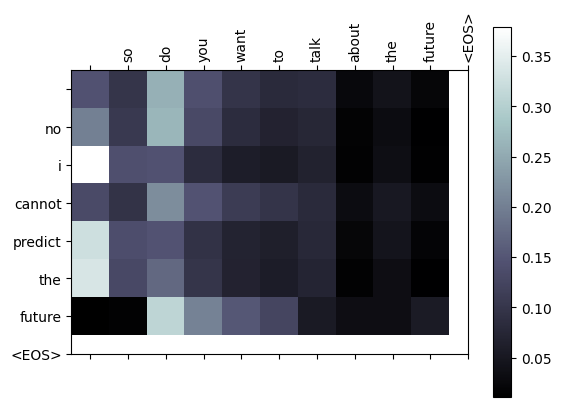

input = but we can talk about the future
output = yes we can but it is too uncertain <EOS>


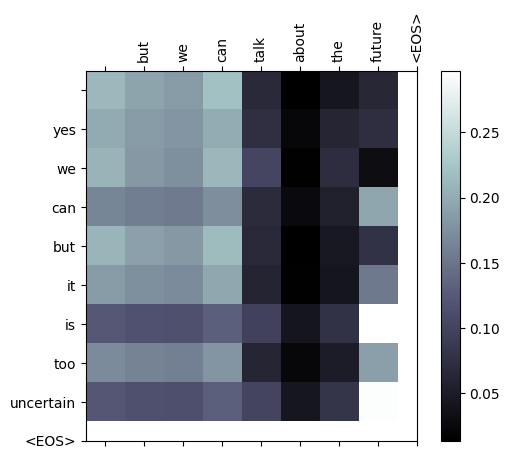

input = good you are learning
output = that is great i love to learn i would like to learn more and more <EOS>


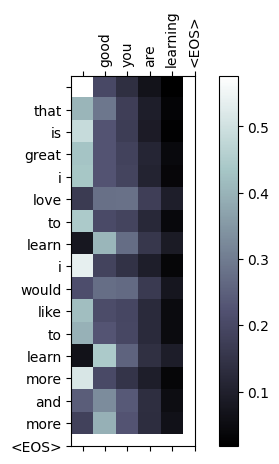

In [82]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Definir os ticks para evitar UserWarnings
    ax.set_xticks(range(len(input_sentence.split(' ')) + 2))
    ax.set_yticks(range(len(output_words) + 1))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.set_yticklabels([''] + output_words)

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, model.input_lang, model.output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


text = clean_text("so do you want to talk about the future")

evaluateAndShowAttention(text)

text = clean_text("but we can talk about the future")

evaluateAndShowAttention(text)

text = clean_text("good you are learning")

evaluateAndShowAttention(text)


# Generative AI Chatbot with reinforcement learning ready to go, i will make another version in portuguese to train in my house and i will deploy in a rapsberry to test the continuous learning